# Notebook to develop and test the ABC Rejection on DAP cell model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm

from delfi.distribution import Uniform
from dap.utils import obs_params_gbar, syn_current
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap.dap_sumstats import DAPSummaryStats
from dap import DAPcython
from dap.dap_simulator import DAPSimulator

### General Settings Pick

In [2]:
n_samples = 100
n_summary = 13
dt = 0.01

### Get current

In [3]:
I, t, t_on, t_off = syn_current(duration=70, dt=dt, t_on=15, t_off=20, amp=3.1)
params, labels = obs_params_gbar(reduced_model=True)
params[0] * 10

0.1527

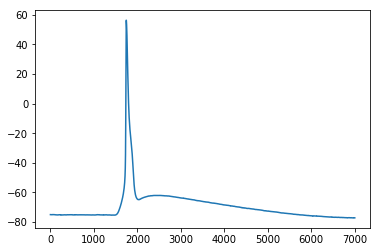

In [4]:
dap = DAPcython(-75, params*10)
U = dap.simulate(dt, t, I)
plt.plot(U);

### Set up the model

In [5]:
sim = DAPSimulator(I, dt, -75, dim_param=1)
stats = DAPSummaryStats(t_on, t_off, n_summary=n_summary)

### Setup Priors

In [6]:
prior_min = np.array([0])
prior_max = np.array([1])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

In [7]:
params = prior_unif.gen(n_samples=2000)
params

array([[0.47560758],
       [0.98612683],
       [0.04617458],
       ...,
       [0.89200673],
       [0.2301235 ],
       [0.58430737]])

### generate desired data

In [8]:
U = dap.simulate(dt, t, I)
y_o = {'data': U.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y = stats.calc([y_o])
y

array([[-75.05683949, 131.37650415,   0.77      , -64.27035326,
         10.27811835,  23.06      ,  -0.50836788,   2.66      ,
        -77.39146766]])

In [9]:
sum_stats = zscore(y, axis=1)
sum_stats

array([[-1.14270841,  2.24640282,  0.10217572, -0.9656217 ,  0.25827487,
         0.46812091,  0.08118816,  0.13320472, -1.18103708]])

## Repeat for 100 in a loop

In [10]:
n_samples = 100
eps = 1

In [11]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [12]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


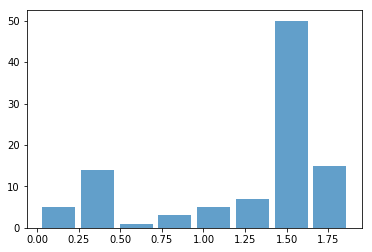

In [13]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [14]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [15]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [16]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

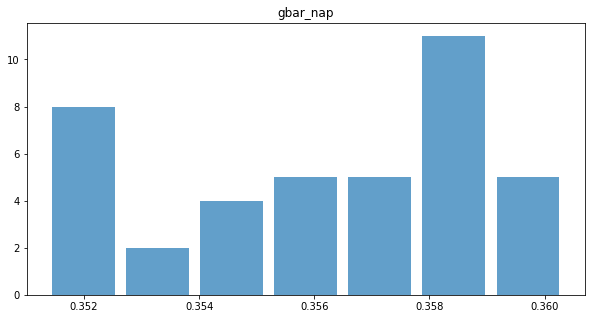

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

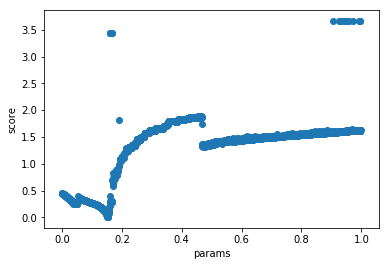

In [38]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

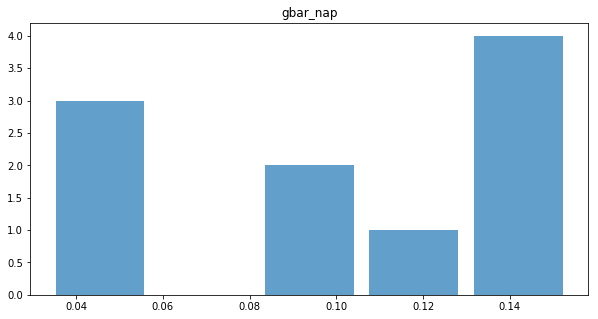

In [19]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

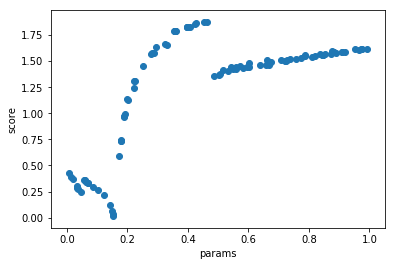

In [20]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

## Repeat for 1000 in a loop

In [21]:
n_samples = 1000
eps = 1

In [22]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [23]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 1000/1000 [03:54<00:00,  4.27it/s]


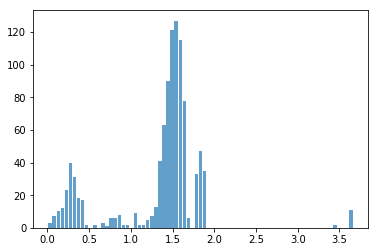

In [24]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [25]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [26]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [27]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean
# params_accept = params[arg_sorted[0:percent_criterion],:]
params_accept = params[arg_sorted[0:percent_criterion],:]*params_mean + params_std

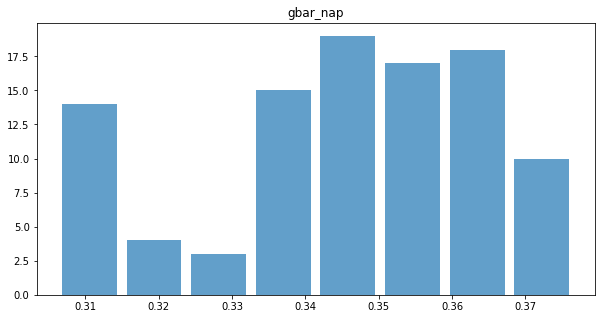

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

## Repeat for 2000 in a loop

In [29]:
n_samples = 2000
eps = 1

In [30]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [31]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 2000/2000 [07:22<00:00,  4.52it/s]


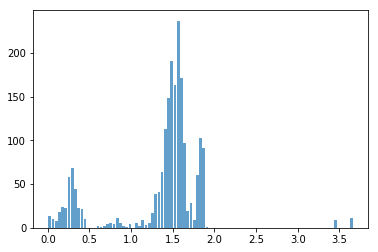

In [32]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [33]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [34]:
# rejection criterion
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [35]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean
# params_accept = params[arg_sorted[0:percent_criterion],:]
params_accept = params[arg_sorted[0:percent_criterion],:]*params_mean + params_std

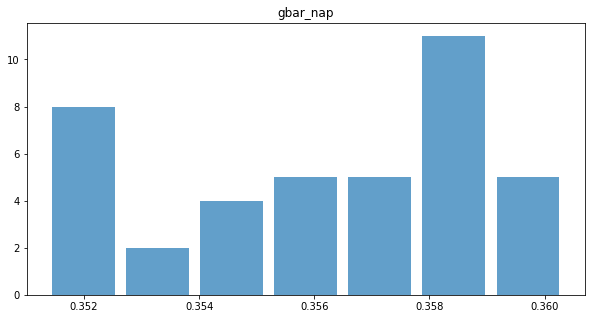

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

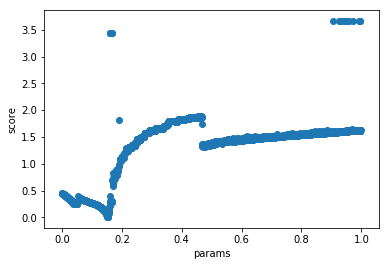

In [39]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

In [43]:
params

array([[0.51720983],
       [0.22671018],
       [0.44857866],
       ...,
       [0.13718249],
       [0.90826769],
       [0.48146616]])

In [44]:
scores

array([1.41842214, 1.30411685, 1.85954799, ..., 0.15594212, 1.58063624,
       1.36025992])

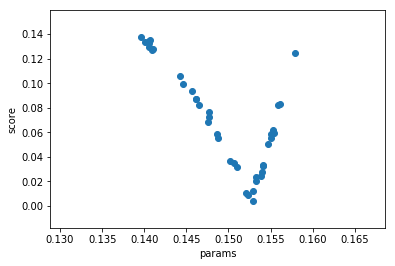

In [50]:
p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

plt.scatter(p, s)
plt.xlabel('params')
plt.ylabel('score');